<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Names : 
# Saeedreza Zouahkiani, Masoud Rahimi, Ehsanollah Shourezari

In [ ]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Checking out files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:48<00:00, 60.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:11<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:11<00:00, 53.5MB/s]


In [ ]:
import torchvision
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install facenet-pytorch --quiet
from facenet_pytorch import MTCNN
from PIL import Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.6 MB/s eta 0:00:00


In [ ]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        with open(self.text_path, 'r') as f:
            self.text = f.readlines()
        self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = Image.open(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)
    

In [ ]:
# create a transform for image that converts the uint8 tensor to float32 and devides by 255
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform)
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform)
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform)

In [ ]:
# create a dataframe for each split
train_df = pd.DataFrame({'text': MSCTD_train.text, 'sentiment': MSCTD_train.sentiment})
dev_df = pd.DataFrame({'text': MSCTD_dev.text, 'sentiment': MSCTD_dev.sentiment})
test_df = pd.DataFrame({'text': MSCTD_test.text, 'sentiment': MSCTD_test.sentiment})

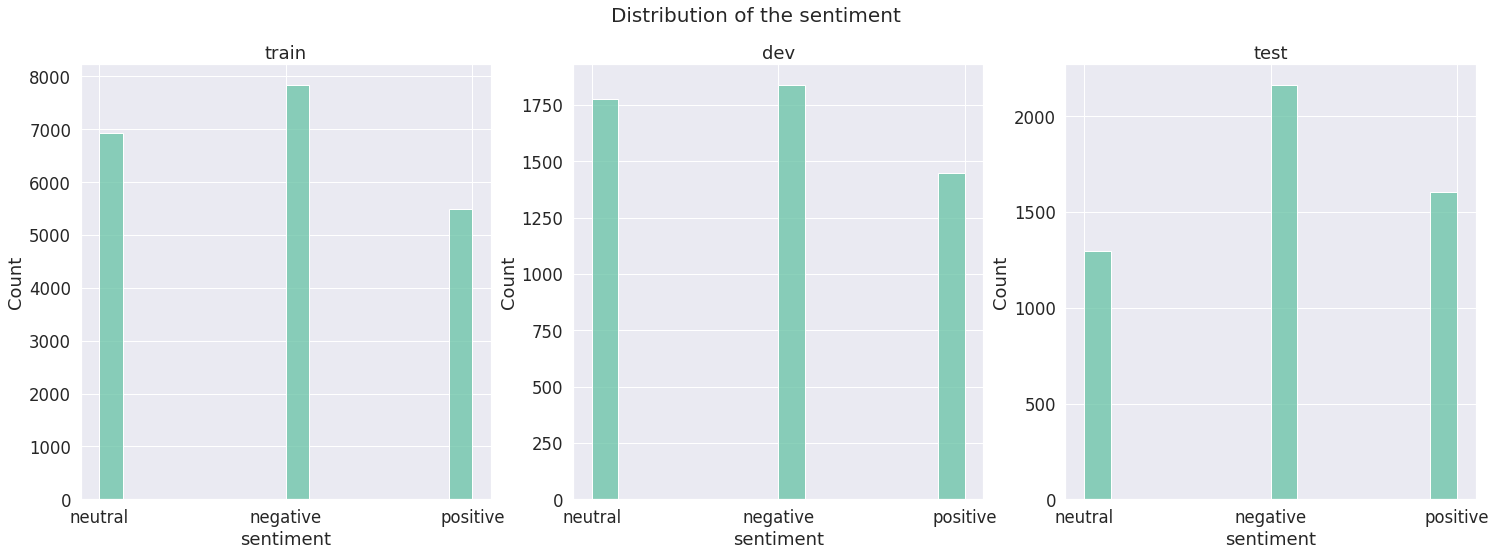

In [ ]:
# plot the distribution of the sentiment
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the sentiment', fontsize=20)
sns.histplot(train_df['sentiment'], ax=ax[0])
ax[0].set_title('train')
# set the x axis to  0, 1, 2
ax[0].set_xticks([0, 1, 2])
# set the x axis to be neutral, negative, positive instead of 0, 1, 2
ax[0].set_xticklabels(['neutral', 'negative', 'positive'])
sns.histplot(dev_df['sentiment'], ax=ax[1])
ax[1].set_title('dev')
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['neutral', 'negative', 'positive'])
sns.histplot(test_df['sentiment'], ax=ax[2])
ax[2].set_title('test')
ax[2].set_xticks([0, 1, 2])
ax[2].set_xticklabels(['neutral', 'negative', 'positive'])
plt.show()

### We can see from the above plot that the train and dev set follow the same pattern, i.e. the train and dev set have the same distribution of labels, but different from the test set. This is a bad sign, because it means that the model will not generalize well to the test set. Also the number of sentiments of each class is not equal so we have an unbalanced dataset.

In [ ]:
# add a new column to the dataframe with the length of the text
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

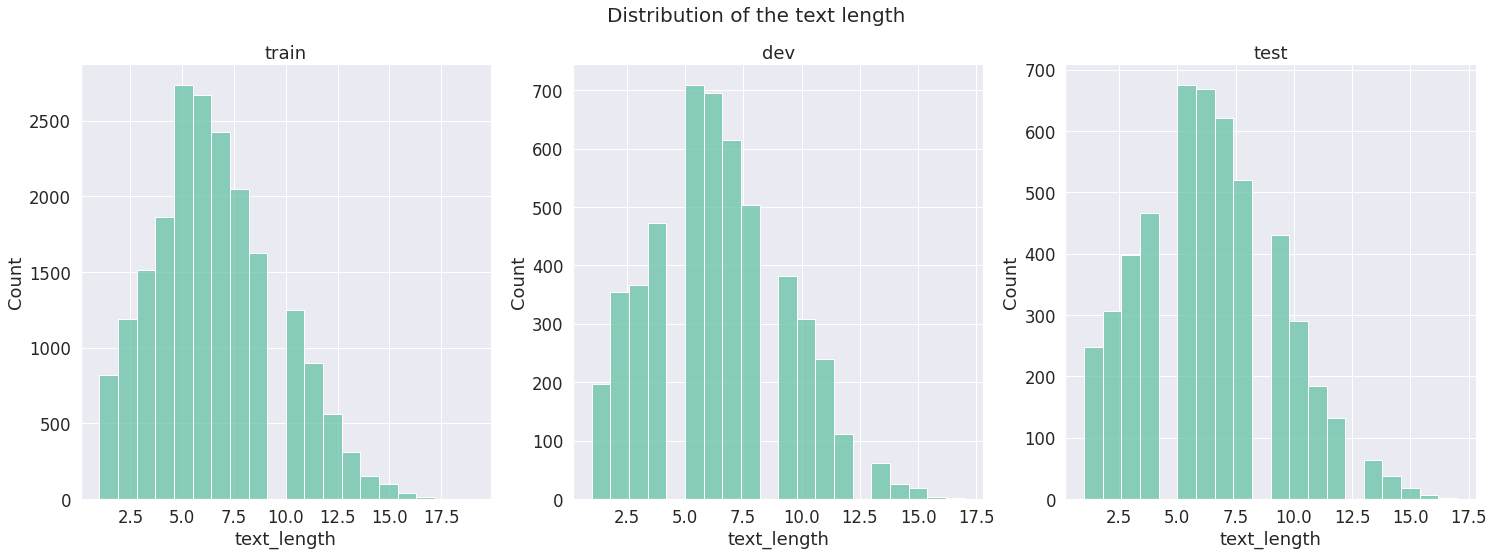

train mean:  6.4644268774703555
train std:  3.0410046435586535
dev mean:  6.310290341694648
dev std:  2.9381055492157224
test mean:  6.303927373199132
test std:  2.9823785621767294


In [ ]:
# plot the distribution of the text length
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the text length', fontsize=20)
sns.histplot(train_df['text_length'], ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_df['text_length'], ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_df['text_length'], ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
# print the mean and standard deviation of the text length
print('train mean: ', train_df['text_length'].mean())
print('train std: ', train_df['text_length'].std())
print('dev mean: ', dev_df['text_length'].mean())
print('dev std: ', dev_df['text_length'].std())
print('test mean: ', test_df['text_length'].mean())
print('test std: ', test_df['text_length'].std())

### The plots show that the train, dev, and test sets havae the same distribution of text length. This is a good sign, because it means that the model will generalize well to the test set using the mentioned feature.

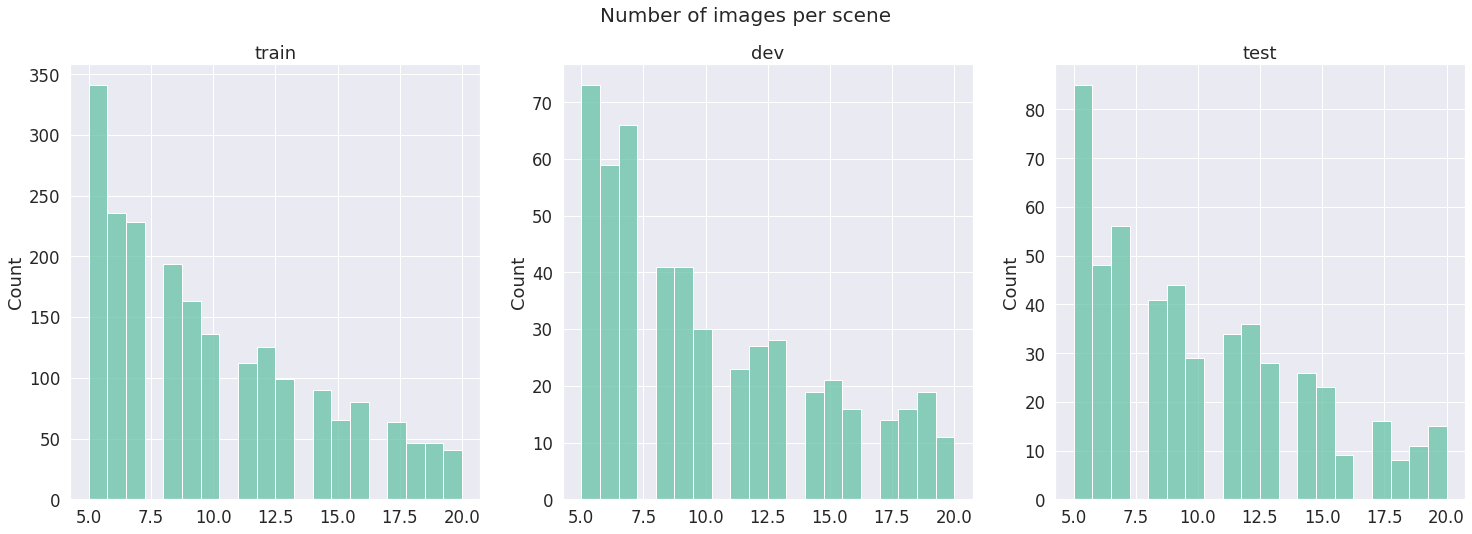

train mean:  9.796708615682478
train std:  4.206700598078209
dev mean:  10.045634920634921
dev std:  4.3879231801583565
test mean:  9.954813359528487
test std:  4.213357164986483


In [ ]:
train_imgs_per_scene = [len(i) for i in MSCTD_train.image_index]
dev_imgs_per_scene = [len(i) for i in MSCTD_dev.image_index]
test_imgs_per_scene = [len(i) for i in MSCTD_test.image_index]
# plot the distribution of the number of images per scene
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Number of images per scene', fontsize=20)
sns.histplot(train_imgs_per_scene, ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_imgs_per_scene, ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_imgs_per_scene, ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
print('train mean: ', np.mean(train_imgs_per_scene))
print('train std: ', np.std(train_imgs_per_scene))
print('dev mean: ', np.mean(dev_imgs_per_scene))
print('dev std: ', np.std(dev_imgs_per_scene))
print('test mean: ', np.mean(test_imgs_per_scene))
print('test std: ', np.std(test_imgs_per_scene))

### We can see that the overall distribution of the dataset over different splits are almost the same, as they also have equal mean and standard deviation. But looking closer at the distribution, we can see that they don't follow the same distribution locally. 

In [ ]:
batch_size = 64
train_loader = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
def num_faces(boxes):
  return [0 if i is None else len(i) for i in boxes]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)
train_faces_per_img = []
dev_faces_per_img = []
test_faces_per_img = []
with torch.no_grad():
  for image, text, sentiment in train_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    train_faces_per_img.append(num_faces(boxes))
  print("train done")
  for image, text, sentiment in dev_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    dev_faces_per_img.append(num_faces(boxes))
  print("dev done")
  for image, text, sentiment in test_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    test_faces_per_img.append(num_faces(boxes))
  print("test done")

train done
dev done
test done


In [ ]:
train_faces_per_img = [item for sublist in train_faces_per_img for item in sublist]
dev_faces_per_img = [item for sublist in dev_faces_per_img for item in sublist]
test_faces_per_img = [item for sublist in test_faces_per_img for item in sublist]
print('train mean: ', np.mean(train_faces_per_img))
print('train std: ', np.std(train_faces_per_img))
print('dev mean: ', np.mean(dev_faces_per_img))
print('dev std: ', np.std(dev_faces_per_img))
print('test mean: ', np.mean(test_faces_per_img))
print('test std: ', np.std(test_faces_per_img))

train mean:  1.5254446640316206
train std:  2.0476644364180214
dev mean:  1.4540786095200473
dev std:  3.476198613380265
test mean:  1.5261495954213538
test std:  1.475628279594663


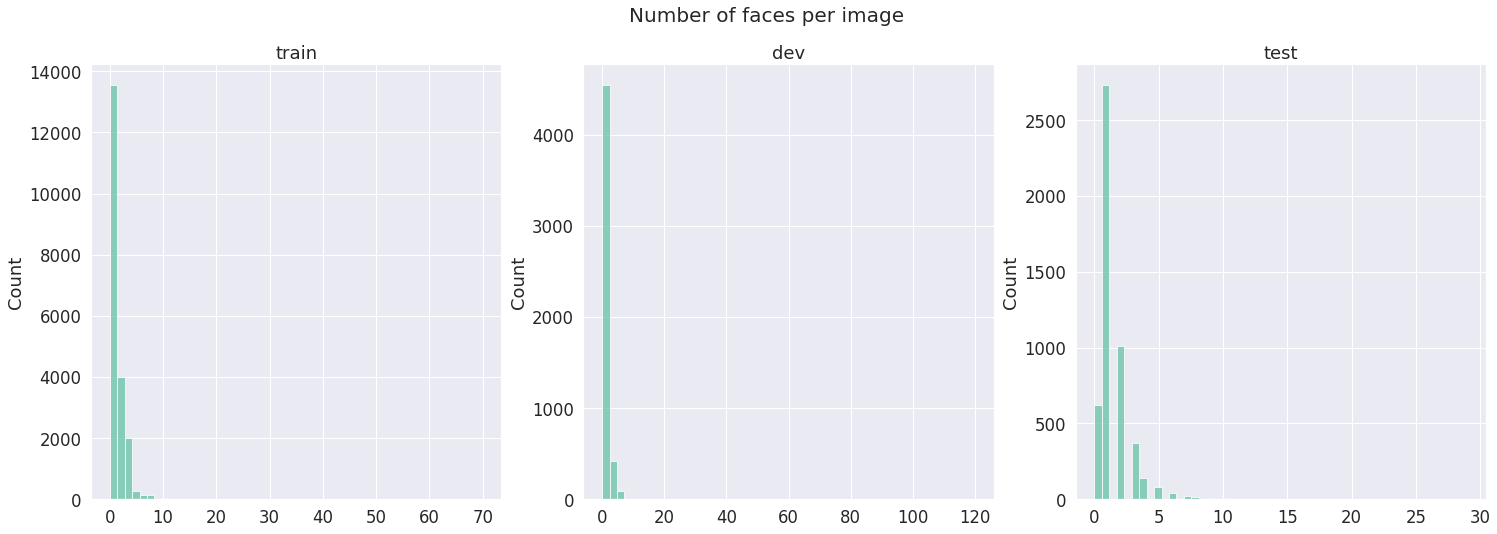

In [ ]:
# plot the distribution of the number of faces per image
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
bins = 50
fig.suptitle('Number of faces per image', fontsize=20)
sns.histplot(train_faces_per_img, ax=ax[0], bins=bins)
ax[0].set_title('train')
sns.histplot(dev_faces_per_img, ax=ax[1], bins=bins)
ax[1].set_title('dev')
sns.histplot(test_faces_per_img, ax=ax[2], bins=bins)
ax[2].set_title('test')
plt.show()


### We can see that the range of number of faces over different splits differ. For example, the dev set has few examples where there are 120 faces, but the train set has at most 70 faces. Also the test set has at most 30 faces. 
### Moreover, the overall distribution of the number of faces is almost equal over different splits. The reason for the difference in the plots is because of their scale in the x-axis

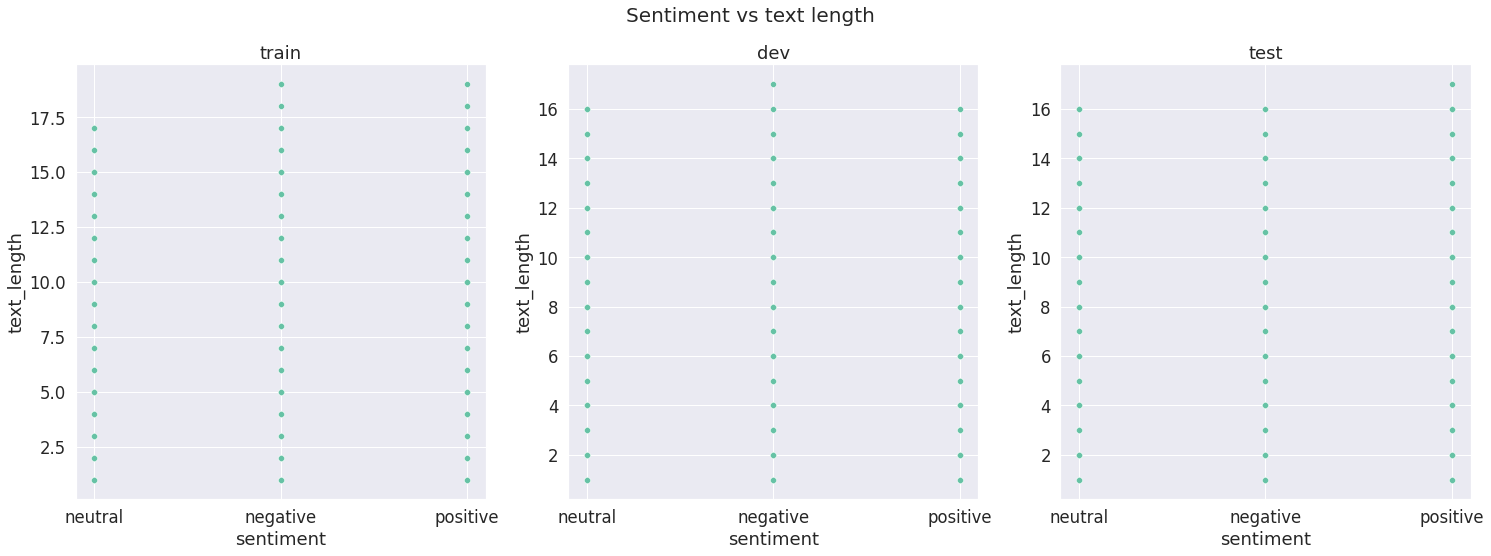

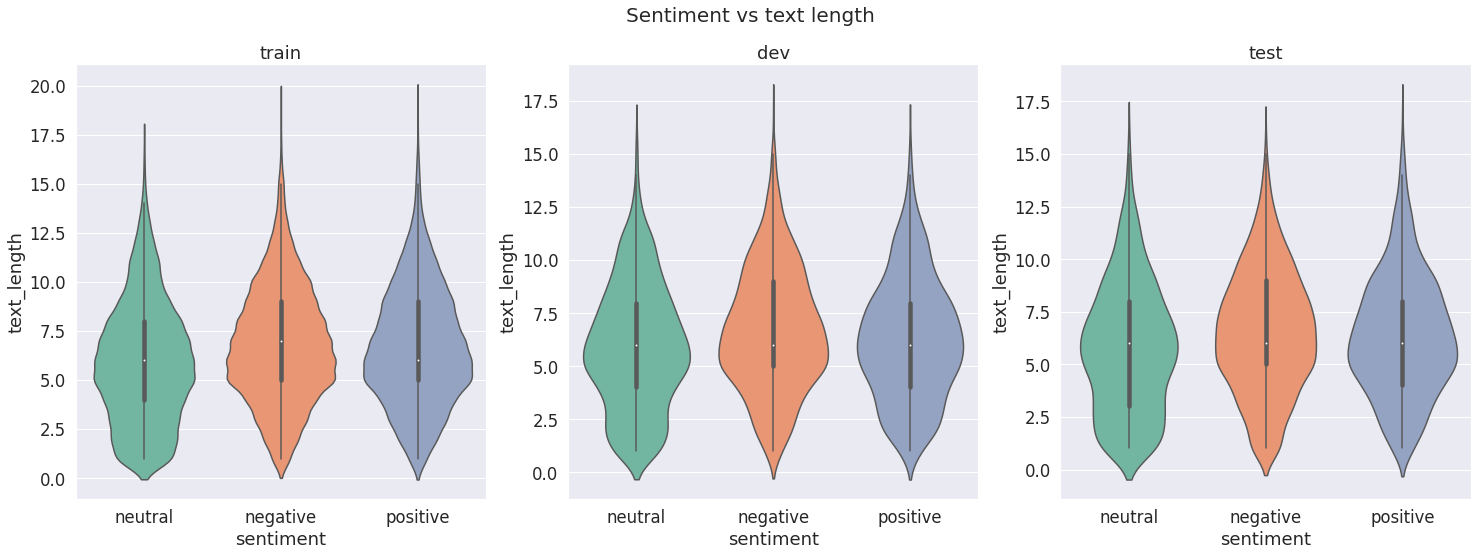

In [ ]:
# scatterplot and violinplot sentiments vs text_length
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Sentiment vs text length', fontsize=20)
sns.scatterplot(x=train_df['sentiment'], y=train_df['text_length'], ax=ax[0])
ax[0].set_title('train')
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['neutral', 'negative', 'positive'])
sns.scatterplot(x=dev_df['sentiment'], y=dev_df['text_length'], ax=ax[1])
ax[1].set_title('dev')
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['neutral', 'negative', 'positive'])
sns.scatterplot(x=test_df['sentiment'], y=test_df['text_length'], ax=ax[2])
ax[2].set_title('test')
ax[2].set_xticks([0, 1, 2])
ax[2].set_xticklabels(['neutral', 'negative', 'positive'])
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Sentiment vs text length', fontsize=20)
sns.violinplot(x=train_df['sentiment'], y=train_df['text_length'], ax=ax[0])
ax[0].set_title('train')
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['neutral', 'negative', 'positive'])
sns.violinplot(x=dev_df['sentiment'], y=dev_df['text_length'], ax=ax[1])
ax[1].set_title('dev')
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['neutral', 'negative', 'positive'])
sns.violinplot(x=test_df['sentiment'], y=test_df['text_length'], ax=ax[2])
ax[2].set_title('test')
ax[2].set_xticks([0, 1, 2])
ax[2].set_xticklabels(['neutral', 'negative', 'positive'])
plt.show()

### We can conclude that when the sentiment is negative, we have on average more words in the diaglogue. Also, the negative and positive examples have very narrow density over fewer text length than the neutral examples. But this pattern happens over different splits

In [ ]:
train_sentiment = []
dev_sentiment = []
test_sentiment = []
for i in MSCTD_train.image_index:
    train_sentiment.append([MSCTD_train.sentiment[j] for j in i])
for i in MSCTD_dev.image_index:
    dev_sentiment.append([MSCTD_dev.sentiment[j] for j in i])
for i in MSCTD_test.image_index:
    test_sentiment.append([MSCTD_test.sentiment[j] for j in i])
    
def sentiment_change(sentiment_index):
    change = []
    for i in sentiment_index:
        temp = [i[0]]
        for j in range(len(i)-1):
            if i[j] != i[j+1]:
                temp.append(i[j+1])
        change.append(temp)
    return change

train_change = sentiment_change(train_sentiment)
dev_change = sentiment_change(dev_sentiment)
test_change = sentiment_change(test_sentiment)

# create a dictionary where the keys are the patterns and the values are their number of occurence and sort them by occurence
def pattern_occurence(change):
    pattern = {}
    for i in change:
        if tuple(i) in pattern:
            pattern[tuple(i)] += 1
        else:
            pattern[tuple(i)] = 1
    pattern = {k: v for k, v in sorted(pattern.items(), key=lambda item: item[1], reverse=True)}
    return pattern

train_pattern = pattern_occurence(train_change)
dev_pattern = pattern_occurence(dev_change)
test_pattern = pattern_occurence(test_change)
print(f"number of unique patterns in train: {len(train_pattern)}")
print(f"number of unique patterns in dev: {len(dev_pattern)}")
print(f"number of unique patterns in test: {len(test_pattern)}")

# remove items with less than 10 occurences
def remove_occurence(pattern):
    pattern = {k: v for k, v in pattern.items() if v >= 10}
    return pattern

train_pattern = remove_occurence(train_pattern)
dev_pattern = remove_occurence(dev_pattern)
test_pattern = remove_occurence(test_pattern)
print(f"number of unique patterns in train that occur at least 10 times: {len(train_pattern)}")
print(f"number of unique patterns in dev that occur at least 10 times: {len(dev_pattern)}")
print(f"number of unique patterns in test that occur at least 10 times: {len(test_pattern)}")


number of unique patterns in train: 681
number of unique patterns in dev: 250
number of unique patterns in test: 255
number of unique patterns in train that occur at least 10 times: 44
number of unique patterns in dev that occur at least 10 times: 5
number of unique patterns in test that occur at least 10 times: 6


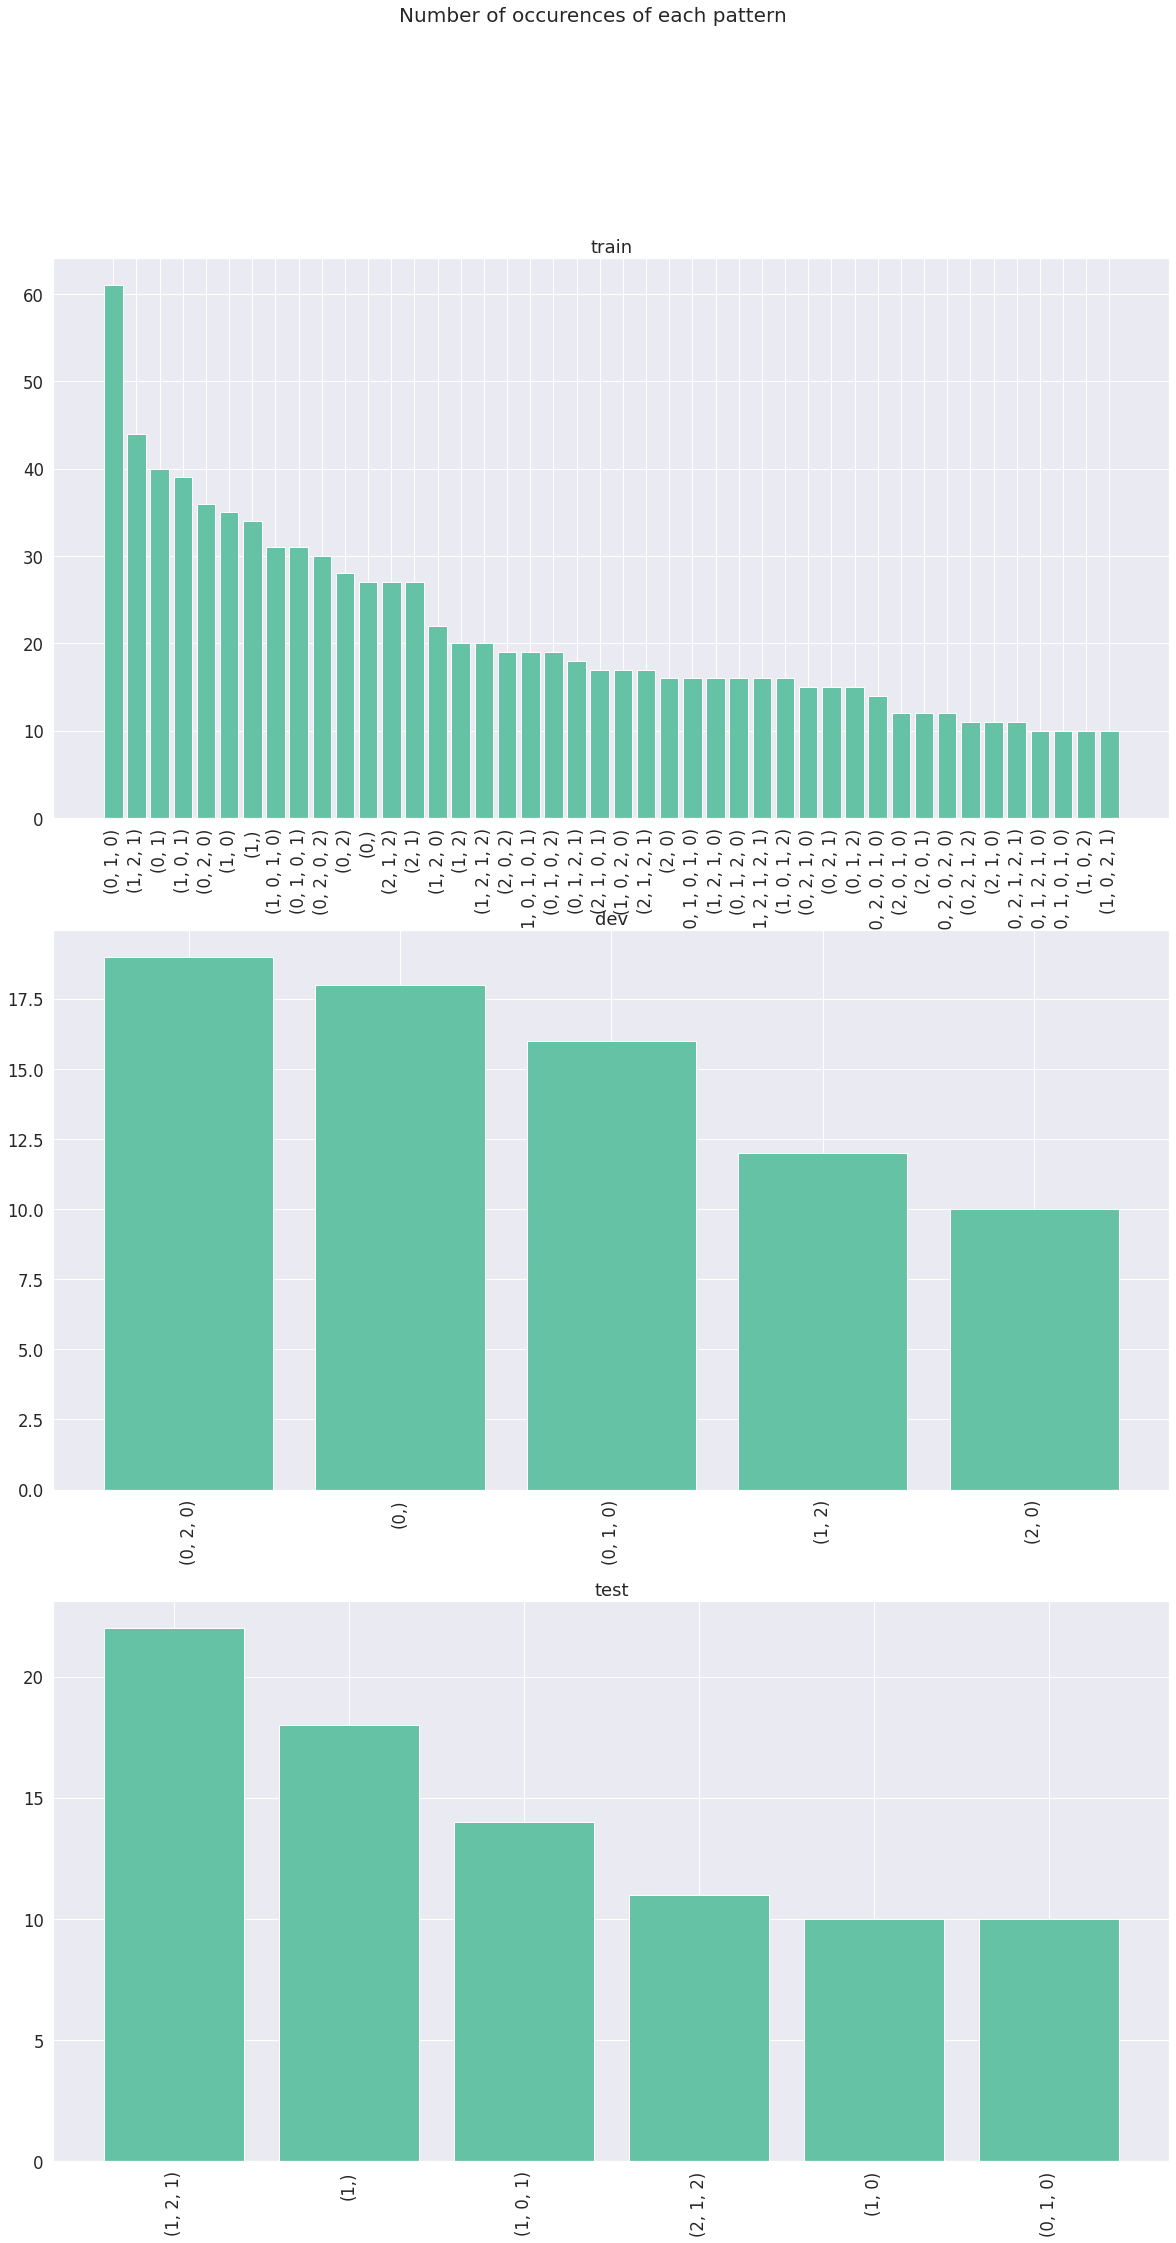

In [ ]:
# plot a histogram where the x-axis is train_change_set and the y-axis is train_change_count
fig, ax = plt.subplots(3, 1, figsize=(20, 35))
fig.suptitle('Number of occurences of each pattern', fontsize=20)
ax[0].bar([str(i) for i in train_pattern.keys()], train_pattern.values())
ax[0].set_title('train')
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[1].bar([str(i) for i in dev_pattern.keys()], dev_pattern.values())
ax[1].set_title('dev')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
ax[2].bar([str(i) for i in test_pattern.keys()], test_pattern.values())
ax[2].set_title('test')
for tick in ax[2].get_xticklabels():
    tick.set_rotation(90)
plt.show()

In [ ]:
# average length of the conversation
train_conv_len = [len(i) for i in MSCTD_train.image_index]
dev_conv_len = [len(i) for i in MSCTD_dev.image_index]
test_conv_len = [len(i) for i in MSCTD_test.image_index]
print('train mean: ', np.mean(train_conv_len))
print('train std: ', np.std(train_conv_len))
print('dev mean: ', np.mean(dev_conv_len))
print('dev std: ', np.std(dev_conv_len))
print('test mean: ', np.mean(test_conv_len))

train mean:  9.796708615682478
train std:  4.206700598078209
dev mean:  10.045634920634921
dev std:  4.3879231801583565
test mean:  9.954813359528487


### The number of possible patterns assuming that the average lenghth of the conversation is 10 words is:
#### $ 3 \times (2^9 + 2^8 + 2^7 + 2^6 + 2^5 + 2^4 + 2^3 + 2^2 + 2^1 + 2^0) = 3 \times 1023 = 3069 $
### But the number of occured patterns in the train, dev, and test sets are 681, 250, 255 respectively. So the number of possible patterns is much larger than the number of occured patterns.
### We can also see that different sentiment patterns happen with different occurrene over different splits. This is a bad sign as the model will not generalize well to the test set.